# 2. Playing around

Author: Arianna Basile, MRC Toxicology Unit, University of Cambridge

__________________________________________________________________________________________________________________
In this tutorial:
<ul>
    <li>You will change the growth medium of your reconstruction (2.1) </li>
    <li>Perform gene essentiality analysis on different conditions (2.2)</li>
    <li>Learn how to change the objective function and simulate the Warburg effect on yeast (2.3) </li>
</ul>


In [4]:
#import the needed packages
import cobra

#enable autocompleting with tab
%config Completer.use_jedi = False


In [79]:
model_yeast=cobra.io.read_sbml_model("iMM904.xml.gz")

## 2.1 Growth media

The availability of nutrients has a major impact on metabolic fluxes and cobrapy provides some helpers to manage the exchanges between the external environment and your metabolic model. In experimental settings the “environment” is usually constituted by the growth medium, ergo the concentrations of all metabolites and co-factors available to the modeled organism. However, constraint-based metabolic models only consider fluxes. Thus, you can not simply use concentrations since fluxes have the unit mmol / [gDW h] (concentration per gram dry weight of cells and hour).

Also, you are setting an upper bound for the particular import flux and not the flux itself. There are some crude approximations. For instance, if you supply 1 mol of glucose every 24h to 1 gram of bacteria you might set the upper exchange flux for glucose to 1 mol / [1 gDW * 24 h] since that is the nominal maximum that can be imported. There is no guarantee however that glucose will be consumed with that flux. Thus, the preferred data for exchange fluxes are direct flux measurements as the ones obtained from timecourse exa-metabolome measurements for instance.

So how does that look in COBRApy? The current growth medium of a model is managed by the medium attribute.

In [8]:
medium=model_yeast.medium
medium

{'EX_fe2_e': 999999.0,
 'EX_glc__D_e': 10.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_so4_e': 999999.0,
 'EX_nh4_e': 999999.0,
 'EX_o2_e': 2.0,
 'EX_pi_e': 999999.0}

This will return a dictionary that contains the upper flux bounds for all active exchange fluxes (the ones having non-zero flux bounds). Right now we see that we have enabled aerobic growth. 
Let's optimize to check the growth in the given medium.

In [23]:
model_yeast.optimize()

,fluxes,reduced_costs
CITtcp,0.000000,0.000000e+00
13BGH,0.000000,-4.751566e-02
13BGHe,0.000000,0.000000e+00
13GS,0.326670,0.000000e+00
16GS,0.000000,0.000000e+00
...,...,...
PYDXO,0.000000,0.000000e+00
PYK,17.721990,1.040834e-17
PYNP2r,0.000000,1.387779e-17
PYR5CDm,0.000000,0.000000e+00


You can modify a growth medium of a model by assigning a dictionary to model.medium that maps exchange reactions to their respective upper import bounds. For now let us enforce anaerobic growth by reducing the oxygen import.

In [77]:
model_yeastv2=model_yeast.copy() #we are making a copy of the original model and editing the copy
medium = model_yeastv2.medium
medium["EX_o2_e"] = 0.00001
model_yeastv2.medium = medium

model_yeastv2.medium

{'EX_fe2_e': 999999.0,
 'EX_glc__D_e': 10.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_so4_e': 999999.0,
 'EX_nh4_e': 999999.0,
 'EX_o2_e': 1e-05,
 'EX_pi_e': 999999.0}

As we can see, the presence of oxygen in our medium has been strongly reduced. Let's check how it influences the growth rate.

In [78]:
model_yeastv2.optimize()

model_yeastv2.objective.value

0.00017940437746681012

The growth rate is reduced


Summing up, we have the same metabolic reconstruction (iMM904) in two different conditions determining two different metabolic models (model_yeast and model_yeastv2).

## 2.2 Gene essentiality

A gene is considered essential if restricting the flux of all reactions that depend on it to zero causes the objective, e.g., the growth rate, to also be zero, below the threshold, or infeasible.

Now we will use the function find_essential_genes to find essential genes in both conditions, extract the IDs of the genes, and compare the two lists. Can you do it by yourself? 

In [65]:
ess_genesv2=cobra.flux_analysis.variability.find_essential_genes(model_yeastv2)
id_ess_genesv2=[]
for gene in ess_genesv2:
    id_ess_genesv2.append(gene.id)

In [54]:
ess_genes=cobra.flux_analysis.variability.find_essential_genes(model_yeast)
id_ess_genes=[]
for gene in ess_genes:
    id_ess_genes.append(gene.id)

In [66]:
print(len(id_ess_genesv2))
print(len(id_ess_genes))


91
110


In [80]:
a=list(set(id_ess_genesv2) & set(id_ess_genes))
len(a)

90

In [68]:
list(set(id_ess_genesv2) - set(id_ess_genes))

['YCR012W']

In [69]:
list(set(id_ess_genes) - set(id_ess_genesv2))

['YDR487C',
 'YBR256C',
 'YJR073C',
 'YLR100W',
 'YGL001C',
 'YJL153C',
 'YHR046C',
 'YGR175C',
 'YOL143C',
 'YGL012W',
 'YBL033C',
 'YBR153W',
 'YOL066C',
 'YHR007C',
 'YHR072W',
 'YGR060W',
 'YHR042W',
 'YER043C',
 'YHR190W',
 'YNL280C']

### Exercises

1) Perform the same analysis but using the function find_essential_reactions (cobra.flux_analysis.variability.find_essential_reactions).

2) Which are the functions of the reactions detected as essential in the model with oxygen? Inspect them with the commands seen in the first notebook

3) Which are the functions of the reactions detected as essential in the model without oxygen? Inspect them with the commands seen in the first notebook

### solution exercise 1

In [86]:
#write your code here...


In [83]:
ess_reacv2=cobra.flux_analysis.variability.find_essential_reactions(model_yeastv2)
id_ess_reacv2=[]
for reaction in ess_reacv2:
    id_ess_reacv2.append(reaction.id)
ess_reac=cobra.flux_analysis.variability.find_essential_reactions(model_yeast)
id_ess_reac=[]
for reaction in ess_reac:
    id_ess_reac.append(reaction.id)
print(len(id_ess_reacv2))
print(len(id_ess_reac))

a=list(set(id_ess_reacv2) & set(id_ess_reac))
len(a)


144
168


['SQLS',
 'LNSTLS',
 'AHCi',
 'DRTPPD',
 'RBFSa',
 'ERGSTter',
 'G6PDH2er',
 'SQLEr',
 'GTPCII',
 'C3STDH2',
 'SQ23EPXter',
 'C3STKR2',
 'DB4PS',
 'C14STR',
 'C24STRer',
 'DADK',
 'C4STMO1',
 'PMETM_SC',
 'SQLter',
 'METAT',
 'C3STKR1',
 'DROPPRy',
 'G6Pter',
 'C4STMO2',
 'RBFSb',
 'MFAPS_SC',
 'DESAT18_2',
 'C3STDH1',
 'ERGTETROLter']

In [84]:
list(set(id_ess_reacv2) - set(id_ess_reac))


['GAPD', 'PGM', 'PGK', 'ENO', 'PYK']

In [85]:
list(set(id_ess_reac) - set(id_ess_reacv2))

['SQLS',
 'LNSTLS',
 'AHCi',
 'DRTPPD',
 'RBFSa',
 'ERGSTter',
 'G6PDH2er',
 'SQLEr',
 'GTPCII',
 'C3STDH2',
 'SQ23EPXter',
 'C3STKR2',
 'DB4PS',
 'C14STR',
 'C24STRer',
 'DADK',
 'C4STMO1',
 'PMETM_SC',
 'SQLter',
 'METAT',
 'C3STKR1',
 'DROPPRy',
 'G6Pter',
 'C4STMO2',
 'RBFSb',
 'MFAPS_SC',
 'DESAT18_2',
 'C3STDH1',
 'ERGTETROLter']

### solution exercises 2 and 3

Use the function model.reactions.get_by_id

## 2.3 Simulate the Warburg effect - Changing the objective function 


Nearly a century ago, Otto Warburg discovered that tumors consume tremendous amounts of glucose relative to most non-transformed tissues, and that the majority of glucose consumed by tumors is fermented to lactate, rather than oxidized in pathways that require respiration. This phenotype is referred to as “aerobic glycolysis,” because unlike carbohydrate fermentation in response to oxygen limitation, aerobic glycolysis involves high levels of fermentation even when oxygen is abundant. Aerobic glycolysis a hallmark of proliferative metabolism found across many kingdoms of life, but is frequently associated with cancer cells, and is known as the Warburg effect in this context.

We simulate the Warburg effect on yeast imposing no oxygen and high glucose intake

In [120]:
model_yeastv3=model_yeast.copy() #we are making a copy of the original model and editing the copy
medium = model_yeastv3.medium
medium["EX_o2_e"] = 0.0
medium["EX_glc__D_e"] = 1000.0
model_yeastv3.medium = medium

model_yeastv3.medium

{'EX_fe2_e': 999999.0,
 'EX_glc__D_e': 1000.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_so4_e': 999999.0,
 'EX_nh4_e': 999999.0,
 'EX_pi_e': 999999.0}

Then we change the objective function to the production of lactate "EX_lac__D_e" and we optimize our model considering the goal of maximizing the lactate production

In [139]:
model_yeastv3.objective = "EX_lac__D_e"
model_yeastv3.optimize().objective_value
model_yeastv3.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,1000,6,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-1000,1,16.68%
etoh_e,EX_etoh_e,-1000,2,33.35%
h_e,EX_h_e,-999.5,0,0.00%
lac__D_e,EX_lac__D_e,-999.5,3,49.98%


Let's do the same exercise with the previously constrained models namely model_yeast and model_yeastv2

In [143]:
model_yeast.objective = "EX_lac__D_e"
model_yeast.optimize().objective_value
model_yeast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
o2_e,EX_o2_e,2,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-9.333,1,15.56%
etoh_e,EX_etoh_e,-7.333,2,24.44%
h2o_e,EX_h2o_e,-2,0,0.00%
h_e,EX_h_e,-12,0,0.00%
lac__D_e,EX_lac__D_e,-12,3,60.00%


In [145]:
model_yeastv2.objective = "EX_lac__D_e"
model_yeastv2.optimize().objective_value
model_yeastv2.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
o2_e,EX_o2_e,1E-05,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-10.5,1,17.50%
etoh_e,EX_etoh_e,-10.5,2,35.00%
h2o_e,EX_h2o_e,-1E-05,0,0.00%
h_e,EX_h_e,-9.5,0,0.00%
lac__D_e,EX_lac__D_e,-9.5,3,47.50%


In both model_yeast and model_yeastv2 the production of lactate is lower than in model_yeastv3, but we can go further and inspect the relationship between glucose availability and the production of lactate in anaerobic conditions (without oxygen). 

In [151]:
glc_concentrations=range(0,1000,10)
lact_prod=[]

for conc in glc_concentrations:
    medium = model_yeastv3.medium
    medium["EX_glc__D_e"] = conc
    model_yeastv3.medium = medium
    model_yeastv3.objective = "EX_lac__D_e"
    model_yeastv3.optimize()
    lact_prod.append(model_yeastv3.optimize().objective_value)


/Users/arianna/miniconda3/envs/carveme2/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/arianna/miniconda3/envs/carveme2/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Now we can plot our results :)

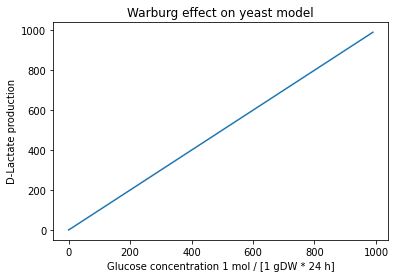

In [156]:
import matplotlib.pyplot as plt
x_axis=glc_concentrations
y_axis=lact_prod
plt.plot(x_axis, y_axis)
plt.title('Warburg effect on yeast model')
plt.xlabel('Glucose concentration 1 mol / [1 gDW * 24 h]')
plt.ylabel('D-Lactate production')
plt.show()

END :)
